### Project 4
### Brendon Happ
### Visualizations

In [68]:
import pandas as pd
import numpy as np
import os
import pickle
import re
from smart_open import smart_open
from time import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

#import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer 
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF, TruncatedSVD

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models.phrases import Phraser, Phrases
from gensim.models.ldamulticore import LdaMulticore

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.grid_objs import Grid, Column #sliders
import plotly.graph_objs as go #horizontal bar charts
import plotly.plotly as py
from plotly import tools #side by side
import networkx as nx


In [2]:
with open('true_df.pickle', 'rb') as f:
    true_df = pd.read_pickle(f)

### Daily Counts

In [3]:
# group by Date, create a count and sort
dailycounts = true_df.groupby(true_df.publish_date.dt.date,as_index=False).size().reset_index(name='counts')
dailycounts = dailycounts.sort_values('publish_date')

In [4]:
trace0 = go.Scatter(
    name = "Tweets Made",
    x=dailycounts.publish_date,
    y=dailycounts.counts,
    line = dict(
        width = 2))
data = [trace0]

layout = go.Layout(
    title = "Daily Tweets",
    yaxis=dict(
        title='Number of Tweets',
        range=[0, 12000],
        titlefont=dict(
            size=20,
        )
    ),
   
    xaxis = dict(
        title='Year',
        range = ['2014-12','2017-5'],
        titlefont=dict(
            size=10,
        )
    ),
    annotations=[dict(y=7730,x='2015-07-22',xref='x',
            yref='y',text='Charleston Church Shooting'),
                dict(y=2836,x='2015-01-20',xref='x',
            yref='y',text='Obama State of the Union Address'),
                dict(y=5919,x='2016-03-22',xref='x',
            yref='y',text='US Election/Trump Wins Arizona Primary'),
                dict(y=8242,x='2016-09-19',xref='x',
            yref='y',text='NY/NJ Bombings'),
                dict(y=6926,x='2016-12-19',xref='x',
            yref='y',text='Trump Earns Required Electoral College Votes'),
                dict(y=17463,x='2016-10-06',xref='x',
            yref='y',text='Wikileaks Releases Clinton Emails'),
                dict(y=4852,x='2015-11-15',xref='x',
            yref='y',text='Paris Attacks')]
)
fig = go.Figure(data=data, layout=layout)
fig['layout'].update(titlefont=dict(size=25))
py.iplot(fig)

### Network Graph

**Get all twitter mentions and hashtags**

In [5]:
true_df.shape

(1995150, 17)

In [6]:
with open('hashtag_mention_df.pickle', 'rb') as f:
    hashtag_mention_df = pd.read_pickle(f)

In [7]:
full_df = true_df.merge(hashtag_mention_df, on='tweet_id')

In [8]:
full_df = full_df.drop(['author_y'], axis=1).rename(columns={'author_x':'author'})

In [9]:
len(full_df.author.unique())

2152

In [10]:
user_mentions = full_df.groupby('author')['mentions'].apply(list)

In [11]:
mentions = []
for user in user_mentions:
    mentions.append([(list(zip(*x))[1]) for x in user if x != []])

In [12]:
import itertools
for index, user in enumerate(mentions):
    mentions[index] = list(itertools.chain(*user))

In [13]:
def f5(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
       # in old Python versions:
       # if seen.has_key(marker)
       # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item.lower())
    return result

In [14]:
for index, user in enumerate(mentions):
    mentions[index] = f5(user)

In [15]:
user_mentions = user_mentions.reset_index()


In [16]:
user_mentions.mentions = mentions

In [17]:
unique_users = set(x.lower() for x in user_mentions.author)

In [18]:
troll_mentions = []
for user in mentions:
    troll_mentions.append([mention for mention in user if mention in unique_users])

In [19]:
user_mentions['troll_mentions'] = troll_mentions

In [20]:
user_mentions.head(10)

,author,mentions,troll_mentions
0,10_GOP,"[nedryun, senatormenendez, carmenyulincruz, cn...","[10_gop, ten_gop, eleven_gop, realten_gop]"
1,1D_NICOLE_,[drgregorywest],[drgregorywest]
2,1ERIK_LEE,[],[]
3,1LORENAFAVA1,"[profosinbajo, bilofausto, italiaonline_it, ki...",[]
4,2NDHALFONION,"[halfonioninabag, cmath_72]",[]
5,4EVER1937,"[potus, elilake, newsweek, medvedevrussia, nav...",[]
6,4EVER_SUSAN,"[cbs, grandfathered, peopleschoice, robdelaney...",[]
7,4MYSQUAD,"[big_gun_in_utah, shaunking, plantflowes, chri...","[gloed_up, 4mysquad, gallowayeliana, johnnymar..."
8,5EMEN5EMENICH,[],[]
9,5L5_5L5,[],[]


In [21]:
authors = [x.lower() for x in user_mentions.author]

In [22]:
connections = []
for i in range(len(authors)):
    it = iter(troll_mentions[i])
    connections.append(list(zip([authors[i]]*len(troll_mentions[i]), it)))

In [23]:
edges = [x for x in connections if x != []]

In [24]:
flat_edges = list(set(item for sublist in edges for item in sublist))

## Plot Troll Network

In [25]:
df_user_followers = full_df.groupby('author')['followers', 'topic'].mean().reset_index()

In [26]:
decimals = pd.Series([0], index=['topic'])

In [27]:
df_user_followers = df_user_followers.round(decimals)

In [28]:
df_user_followers.topic = df_user_followers.topic.astype('int')

In [29]:
df_user_followers['author'] = authors

In [30]:
df_user_followers.head()

,author,followers,topic
0,10_gop,7045.666667,2
1,1d_nicole_,51.394737,3
2,1erik_lee,74.000000,4
3,1lorenafava1,81.816667,2
4,2ndhalfonion,1.000000,4


In [31]:
connected_users = set()
for user in df_user_followers.author:
    for edge in flat_edges:
        if user not in edge:
            continue
        else:
            connected_users.add(user)

In [32]:
df_user_followers.loc[df_user_followers.author.str.contains('news'), 'topic'] = 0

In [33]:
df_user_followers.loc[df_user_followers.author.str.contains('today'), 'topic'] = 0

In [34]:
df_user_followers = df_user_followers[df_user_followers.author.isin(connected_users)]

In [65]:
top_users = df_user_followers.sort_values('followers', ascending=False)[0:10]

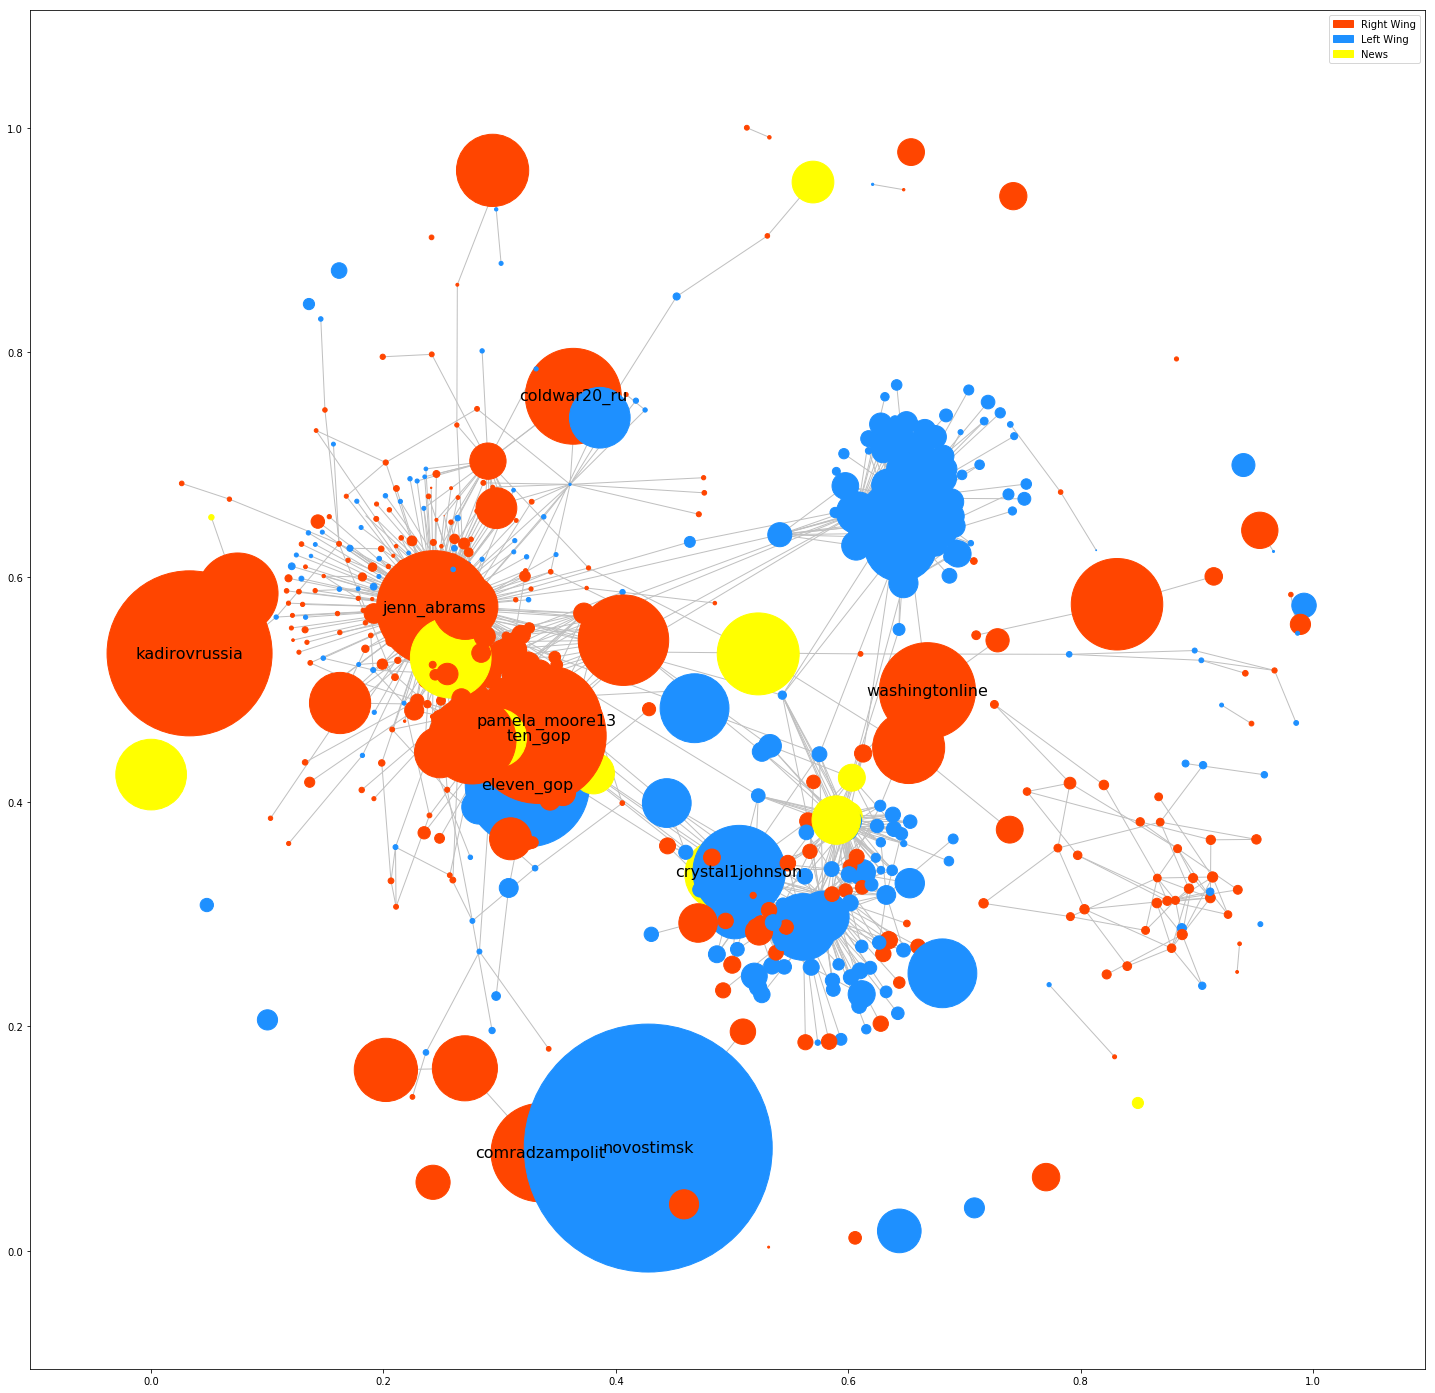

In [79]:
import warnings
warnings.filterwarnings('ignore')
labels = {}

G = nx.Graph()

for index, row in df_user_followers.iterrows():
    G.add_node(row['author'], group=row['topic'], nodesize=row['followers'])
    
for node_a, node_b in flat_edges:
    G.add_edge(node_a, node_b)  #add_weighted_edges_from([(row['source'], row['target'], row['value'])])
    
color_map = {0:'#FFFF00', 1:'#1e90ff', 2:'#FF4500', 3:'#1e90ff', 4:'#1e90ff', 5:'FFFF00'} 

plt.figure(figsize=(25,25))

colors = [color_map[G.node[node]['group']] for node in G]
sizes = [G.node[node]['nodesize']*.3 for node in G]

labels = {}    
for user in top_users.author:
    labels[user] = user
        
pos=nx.spring_layout(G, k=1/(.1*np.sqrt(len(G.node))), iterations=200)
"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors)
nx.draw_networkx_edges(G, pos, edge_color='#C0C0C0')
nx.draw_networkx_labels(G, pos, labels, font_size=16)

news = mpatches.Patch(color="#FFFF00", label = 'News')
right = mpatches.Patch(color="#FF4500", label = 'Right Wing')
left = mpatches.Patch(color="#1e90ff", label = 'Left Wing')
plt.legend(handles=[right, left, news])

plt.savefig(filename='network.jpg')
plt.show()

    